In [1]:
import os
import re
from datetime import datetime
import pickle
import codecs
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import ensemble
from sklearn import metrics

#import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
print (datetime.today())

2016-09-26 16:31:56.968679


### 1. Load in all training data from pickle

In [3]:
# Load data from pickle
all_data_pkl = open("all_data.pkl", 'rb')
all_data = pickle.load(all_data_pkl)

all_data[:3]

,id,call,ex_tag,txt
0,CTRL000000096,0,0,Subject FW Quality Moves to utilize on your ...
1,CTRL000000097,0,0,Subject Schedule confirmation From guzman M...
2,CTRL000000099,0,0,Subject Emergency Meeting From williams iii...


In [4]:
all_data['txt'][1]

'Subject  Schedule confirmation From  guzman  Mark    o enron ou na cn recipients cn mguzman    Date  Mon     Nov                     To  DL Portland Real Time Shift    o enron ou na cn recipients cn dl portlandrealtimeshift     Starting a few days ago  Lotus notes has been eliminated as a format for inputing schedule confirmation and cut schedule information   The new process is done in Enpower   Cara sent a notice out last week and I have left a copy of the new process instruction manual on the Real Time desk   Please take the time to check it out   For our purposes we will basically only need to read thru the Path Confirmation instructions   I had a chance to test out this new process a few weeks ago and it is far better than Lotus Notes and works effectively   If you have any questions feel free to ask Cara or myself   Thank you for your attention to this matter               EDRM Enron Email Data Set has been produced in EML  PST and NSF format by ZL Technologies  Inc  This Data S

### 2. Preprocess text

In [3]:
# function to preprocess the text of the documents
def txt_to_words(raw_txt):
    
    # Remove HTML markup
    txt_text = BeautifulSoup(raw_txt,"html.parser").get_text() 
    
    # Remove non-alphabets and doc starter
    letters_only = re.sub("[^a-zA-Z]", " ", txt_text).replace(u'\ufeff','')
    
    # To lower case
    letters_only_lower = letters_only.lower()
    
    return letters_only_lower

In [4]:
# Apply the preprocess function txt_to_words to "txt" column
all_data['txt'] = all_data['txt'].map(txt_to_words)

# See what's inside
all_data[:3]

,id,call,ex_tag,txt
0,CTRL000000096,0,0,subject fw quality moves to utilize on your ...
1,CTRL000000097,0,0,subject schedule confirmation from guzman m...
2,CTRL000000099,0,0,subject emergency meeting from williams iii...


In [5]:
all_data_preprocessed_pkl = open("all_data_preprocessed.pkl","wb")
pickle.dump(all_data, all_data_preprocessed_pkl)
all_data_preprocessed_pkl.close()

### 3. Create training/test mask

In [6]:
# Get doc id for training set
train_docid = []
f_train_docid = open("train_id.txt","r")
for line in f_train_docid:
    file_name = line.lstrip().rstrip()
    train_docid.append(file_name)
f_train_docid.close()

# See what's inside
print(len(set(train_docid)))  # Check uniqueness
print(train_docid[:3])

train_mask = np.where([i in train_docid for i in all_data['id']])[0]
test_mask = np.where([i not in train_docid for i in all_data['id']])[0]

660
['CTRL000052948', 'CTRL000053534', 'CTRL000054613']


### 4. Fit a CountVectorizer on the whole corpus (training + test)

In [36]:
# Vectorization - count

# timing
start_time = datetime.today()

# Instantiate CountVectorizer
vectorizer = CountVectorizer(
                             encoding='utf-8-sig',
                             max_features = 2000,
                             ngram_range=(1, 1),
                             stop_words='english',
                             max_df= .95
                             )
vectorizer.fit(all_data['txt'])
txt_BOW = vectorizer.transform(all_data['txt'])

print (datetime.today() - start_time)
# 2:05 for bi-gram
# 3:37 for tri-gram
# 0:54 for binary uni-gram


# See what's it like
print (txt_BOW.shape)
type(txt_BOW)



0:00:55.182721
(104541, 2000)


scipy.sparse.csr.csr_matrix

### 5. Split train and test set

In [37]:
X_train = txt_BOW[train_mask,:]
X_test = txt_BOW[test_mask,]
Y_train = all_data.iloc[train_mask,]['call']
Y_test =  all_data.iloc[test_mask,]['call']

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(660, 2000)
(103881, 2000)
(660,)
(103881,)


### 6. Fit a default RandomForest Classifier

In [38]:
# Set up RF classifier - Default
rf_default = ensemble.RandomForestClassifier(random_state = 1)
rf_default.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [39]:
pred_rf_default = rf_default.predict(X_test)

In [42]:
print (metrics.confusion_matrix(Y_test, pred_rf_default, labels = ['1','0']))

accuracy = (metrics.accuracy_score(Y_test, pred_rf_default))
precision = (metrics.precision_score(Y_test, pred_rf_default, pos_label = '1', average = 'binary'))
recall = (metrics.recall_score(Y_test, pred_rf_default, pos_label = '1', average = 'binary'))
f1 = recall = (metrics.f1_score(Y_test, pred_rf_default, pos_label = '1', average = 'binary'))
print ("Accuracy: %f;\n Precision: %f;\n Recall: %f;\n f1 score: %f" %(accuracy, precision, recall, f1))

[[ 1081 13906]
 [  754 88140]]
Accuracy: 0.858877;
 Precision: 0.589101;
 Recall: 0.128522;
 f1 score: 0.128522


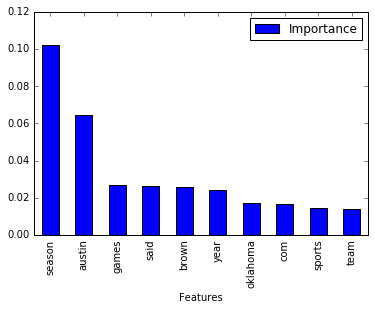

In [41]:
feature_df = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                           "Importance": rf_default.feature_importances_
                          })
feature_df.sort_values('Importance', ascending = False)[:10].plot(x = 'Features', y = 'Importance', kind='bar')